In [4]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from bokeh.io import show
from bokeh.models import ColumnDataSource
from bokeh.palettes import RdBu3
from bokeh.plotting import figure
from bokeh.plotting import *
# from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.models import *
from bokeh.io import output_notebook
import seaborn as sns

In [5]:
# read in all data
df = pd.read_csv('data/all.csv', dtype=str)
df.shape

(896541, 32)

In [6]:
df.columns

Index(['Unnamed: 0', 'venue', 'title', 'abstract', 'year', 'articledate',
       'doi', 'pmid', 'pii', 'pmc', 'abstract_pre', 'tiabs', 'lang', 'delta',
       'covid', 'pid', 'source_x', 'pmcid', 'pubmed_id', 'license',
       'publish_time', 'authors', 'journal', 'Microsoft Academic Paper ID',
       'WHO #Covidence', 'has_full_text', 'full_text_file', 'journal-short',
       'pubdate', 'issns', 'publisher', 'cr_dates'],
      dtype='object')

In [7]:
# X_dense = np.load('data/all_scispacy_vecs.npy')

In [8]:
# X_dense.shape

(917811, 200)

In [66]:
xy = np.load('data/2d_scispacy_s2_pubmed_all_corpus.npy')
xy.shape

AssertionError: 

In [ ]:
# check that data is the correct shape
assert xy.shape[0] == df.shape[0]
df['x'] = xy[:,0]
df['y'] = xy[:,1]
df.shape

In [ ]:
# subset the pubmed stuff
df = pd.concat([df[df['covid']=='0'].sample(10000, random_state=100), df[df['covid']=='1']])
df.shape

In [9]:
import spacy
from tools import pre_s, add_check_cols
spacy.prefer_gpu()
output_dir = 'models/spacy_textcategorizer'
nlp = spacy.load(output_dir)

In [10]:
df = add_check_cols(df)

out = []
for i,row in df.iterrows():
    text = str(row['tiabs'])
    abstract = str(row['abstract_pre'])
    if (len(text.split())>=20) and (len(text.split())<500):
        doc = nlp(text)
        out.append((doc.cats['POSITIVE'],doc.cats['NEGATIVE']))
    elif 'no abstract' in abstract or 'abstract not req' in abstract:
        out.append(('********* Abstract missing? *********','********* Abstract missing? *********'))
    else:
        out.append(('********* Input too short/long *********','********* Input too short/long *********'))


df['prob'] = [x[0] for x in out]
df['pred'] = [1 if type(x[0])==float and x[0]>=0.5 else 0 for x in out]

adding keyword checks to dataframe (896541, 32)


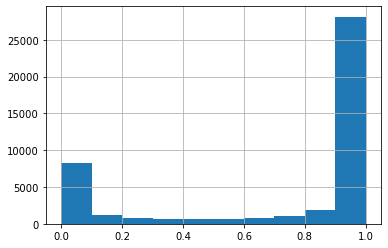

In [62]:
df['prob'].hist()

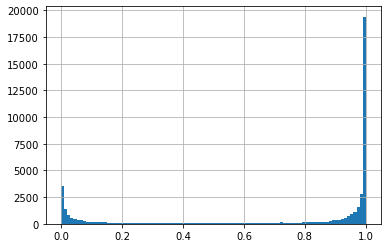

In [63]:
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
# choose a scaler
scaler = MinMaxScaler() # StandardScaler()# RobustScaler() # Normalizer() # 
scaler.fit(np.array(df['prob'].values).reshape(-1, 1))
transformed_probs = scaler.transform(np.array(df['prob'].values).reshape(-1, 1))
df['prob_normed'] = transformed_probs # 0.1*(transformed_probs[:,0]+5)
df['prob_normed'].hist(bins=100)

In [64]:
df['prob_normed'].max(), df['prob_normed'].min()

(1.0, 0.0)

## Colour clusters by average citation rates
This is where we define our colour scheme. 

In [ ]:
# !conda install seaborn

In [ ]:
import seaborn as sns
sns.palplot(sns.color_palette("YlOrRd", 50))#[::-1])

In [ ]:
n_colours = 20

# define the palette
palette = sns.color_palette("YlOrRd", n_colours+1).as_hex()[::-1] # note +1 to fix rounding errors

i=0
colours=[]
colour_numerics = []
for prob in df['prob_normed'].tolist():
    colour_no = max(int((n_colours-1)*(prob)),0)
#     print(colour_no)
    colour_numerics.append(colour_no)
    colr = palette[colour_no]
    colours.append(colr)
    i+=1
df['colour'] = colours

Check the distribution of the colours.  In some datasets, you'll find a poor distribution of red/orange/yellow simply due to the distribution of citations in the dataset.  Worth fiddling with the code to make the diferences stand out.  

In [ ]:
pd.Series(colour_numerics).hist()

## Visualisation

In [ ]:
%%time
every_nth = 1 # recommend setting this to 20 for 'train' datasets
n_features = 500

In [ ]:
df['index'] = df.index
df.head()

# Add a colours column

In [ ]:
# add links so that datapoints are clickable

links = []
for i,row in df.iterrows():
    if len(str(row['doi']))>3:
        links.append('http://doi.org/'+str(row['doi']))
    elif len(str(row['pmid']))>3:
        links.append('https://www.ncbi.nlm.nih.gov/pubmed/?term='+str(row['pmid']))
    else:
        links.append('https://www.semanticscholar.org/paper/'+str(row['pid']))

df['Link'] = links

# Quick visualise with MatplotLib
This visualisation doesn't use a lot of memory and gives us a png image of the data which is easy to share. The 

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df['x'], 
            df['y'], 
            s= 5, 
            c=colours, 
            cmap='Spectral',
           alpha = 0.4)
plt.title('Embedding of the CORD-19 dataset plus a sample of Pubmed', fontsize=16);
plt.savefig('output/S2_plt.png')

## Bokeh code
The first step is to define a few things that will go into the plot.

#### Hover tool
The hover tool defines what happens when you hover your mouse over the plot. 

In [ ]:
hover = HoverTool(
        tooltips=[
#             ("index", "$index"),
#             ("(x,y)", "($x, $y)"),
            ("Journal", "@venue"),
            ("DOI", "@doi"),
            ("Title","@new_title"),
            ("Probability","@prob"),
            ('Year','@year'),
                ])

In [ ]:
output_notebook()

In [ ]:
# which interactive tools do we want to include with the visualisation?
TOOLS = [BoxSelectTool(), hover, 'tap','box_zoom','reset', 'crosshair',
         'pan','wheel_zoom','previewsave'] #,HoverTool()] # just say 'HoverTool()' for the default

In [ ]:
# set the transparency of datapoints 
df['Alpha'] = 0.2

## Build plot
This is where we define the figure itself using the Bokeh package.

In [ ]:
# df['covid'] = df['covid'].map(lambda x: str(x))

In [ ]:
# df = df[['x','y','covid','Alpha','doi','venue','title','year']]

In [ ]:
# https://stackoverflow.com/questions/41856999/bokeh-plots-just-bring-up-a-blank-window
# BOKEH_RESOURCES=inline
plot_title = 'Classification of CORD-19 dataset (yellow) and random sample of PubMed (red)'

# plotting
p = figure(plot_width=1200, plot_height=800,
           title=plot_title,  # specified in the config file!
           tools=TOOLS,
          x_axis_label = "Textual similarity axis_1 (arbitrary units)",
          y_axis_label = 'Textual similarity axis_2 (arbitrary units)') # , active_inspect=None)

# p.toolbar.active_inspect = ['crosshair', hover]

p.background_fill_color = "black"

p.circle(x = 'x' , 
         y = 'y', 
#           legend = 'Division',
         size = 5, # 'Sizes',
         color = 'colour',
         alpha = 'Alpha', 
         line_alpha = 0,
         legend = 'pubmed',
         source = ColumnDataSource(df[df['covid']=='0']))  # This conversion to ColumnDataSource is crucial.

p.circle(x = 'x' , 
         y = 'y', 
#           legend = 'Division',
         size = 5, # 'Sizes',
         color = 'colour',
         alpha = 'Alpha', 
         line_alpha = 0,
         legend = 'cord-19',
         source = ColumnDataSource(df[df['covid']=='1']))  # This conversion to ColumnDataSource is crucial.

p.legend.location = "top_right"
p.legend.click_policy="hide"
# p.legend.text = ['No journal' if len(x)<=3 else 'published' for x in df['venue']]


# drop gridlines
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

output_file('output/d2v_bokeh_classifier.html',
           mode = 'inline')  # toggle for write-to-file



# add links
url = "@Link"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

In [ ]:
show(p)